### Copyright (C) 2022 Sobhan Moradian Daghigh and s.o who's unknown :)
### Date: 2/20/2022 

In [1]:
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
class Environment(EnvironmentBase):
    
    obstacles = [(1, 7), (1, 8), (2, 7), (2, 8), (3, 7), (3, 8), (4, 7), (4, 8),
                (12, 6), (12, 7), (13, 6), (13, 7), (14, 6), (14, 7), (15, 6), (15, 7),
                (8, 13), (8, 14), (8, 15), (9, 13), (9, 14), (9, 15)]
    
    def __init__(self, actionPrice, goalReward, punish, obstacles=obstacles,
                 i_limit=15, j_limit=15, p=0.8, goal=(1, 1), start=(15, 15), container=None):
        """ initialize your variables """
        
        state_space = gym.spaces.MultiDiscrete([i_limit, j_limit])
        action_space = gym.spaces.Discrete(9)
        super(Environment, self).__init__(action_space, state_space, container)
        self.state_space = state_space
        self.obstacles = obstacles
        self.actionPrice = actionPrice
        self.goalReward = goalReward
        self.punish = punish
        self.i_limit = i_limit
        self.j_limit = j_limit
        self.p = p
        self.goal = goal
        self.start = start
        self.state = start
        self.state_p = None
        
        
    # -------------------------------------------------------------------------------------------------------------    
    def isStatePossible(self, state):
        """if given state is possible (not out of the grid and not obstacle) return ture"""
        
        i_in = range(1, self.i_limit + 1)
        j_in = range(1, self.j_limit + 1)
        
        return False if state in self.obstacles or state[0] not in i_in or state[1] not in j_in else True
    
    
    # -------------------------------------------------------------------------------------------------------------
    def isAccessible(self, state, state_p):
        """if given state is Accesible (we can reach state_p by doing an action from state) return true"""

        if self.isStatePossible(state) and self.isStatePossible(state_p):
            if (np.abs(np.subtract(state, state_p)) <= (1, 1)).all():
                return True
        return False
    
    
    # -------------------------------------------------------------------------------------------------------------
    def getTransitionStatesAndProbs(self, state, action, state_p):
        """return probability of transition or T(sp,a,s)"""

        _, actions = self.available_actions(state)
        if action in actions:
            available_states = self.available_states(actions, state)
            
            if self.next_state(action, state) == state_p:
                return self.p
            
            elif state_p in available_states:
                return (1 - self.p) / (len(available_states) - 1)
            
            else: return 0
        else: return 0
    
    
    # -------------------------------------------------------------------------------------------------------------
    def getReward(self, state, action, state_p):
        """return reward of transition"""
        
        # The Goal Achieved
        if state_p == self.goal:
            return self.goalReward
        
        elif self.isAccessible(state, state_p):
            return self.actionPrice
        
        # Hit the obstacles
        else:
            return self.punish
        
            
    # -------------------------------------------------------------------------------------------------------------
    def calculate_reward(self, action):
        return
    
    
    # -------------------------------------------------------------------------------------------------------------
    def terminated(self, state):
        return state == self.goal
    
    
    # -------------------------------------------------------------------------------------------------------------
    def available_actions(self, state):
        actions = []
        numbers = []
        num = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                state_p = tuple(np.add(state, (j, i)))
                if self.isAccessible(state, state_p):
                    actions.append((j, i))
                    numbers.append(num)
                num += 1
                    
        return numbers, actions
    
    
    # -------------------------------------------------------------------------------------------------------------
    def action_num2dim(self, num):
        if num < 3:
            return (np.mod(num, 3) -1, -1)
        elif num < 6:
            return (np.mod(num, 3) -1, 0)
        else:
            return (np.mod(num, 3) -1, 1)
        
        
    # -------------------------------------------------------------------------------------------------------------
    def get_states(self):
        states = []
        for i in range(1, self.i_limit + 1):
            for j in range(1, self.j_limit + 1):
                if self.isStatePossible((i, j)):
                    states.append((i, j))
        return states
    
    
    # -------------------------------------------------------------------------------------------------------------
    def available_states(self, actions, state):
        states_p = []
        for action in actions:
            states_p.append(self.next_state(action, state))
        return states_p
                
    
    # -------------------------------------------------------------------------------------------------------------
    def next_state(self, action, state):
        return tuple(np.add(state, action))

    
    # -------------------------------------------------------------------------------------------------------------
    def reset(self):
        self.state = self.start
        
        
    # -------------------------------------------------------------------------------------------------------------
    def observe(self):
        return self.state
    
    
    # -------------------------------------------------------------------------------------------------------------
    def render(self):
        return 
    
    
    # -------------------------------------------------------------------------------------------------------------
    def close(self):
        return
    

In [13]:
class Agent(AgentBase):
    def __init__(self, environment, theta=0.1, discount=0.9, free_stay=False):
        #initialize a random policy and V(s) = 0 for each state
        self.environment = environment

        self.width  = self.environment.i_limit
        self.height = self.environment.j_limit
        
        #init V
        self.V = [[0] * (self.width + 1) for _ in range(self.height + 1)]
        
        #init policy
        self.policy = np.random.randint(0, 9, (self.width + 1, self.height + 1))
        
        super(Agent, self).__init__(id, environment)
        self.discount = discount
        self.theta = theta
        self.free_stay = free_stay
        
    
    # -------------------------------------------------------------------------------------------------------------
    def policy_evaluation(self):        
        while True:
            delta = 0
            pre_delta = delta
            for state in self.environment.get_states():
                v = self.V[state[0]][state[1]]                
                action = self.policy[state[0]][state[1]]                
                numbers, actions = self.environment.available_actions(state)
                value = 0
                for act in actions:
                    state_p = self.environment.next_state(act, state)
                    if self.free_stay:
                        reward = 0 if act == (0, 0) else self.environment.getReward(state, environment.action_num2dim(action), state_p)                       
                    else:
                        reward = self.environment.getReward(state, environment.action_num2dim(action), state_p)
                    probability = self.environment.getTransitionStatesAndProbs(state, environment.action_num2dim(action), state_p)
                    value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])

                self.V[state[0]][state[1]] = value

                pre_delta = delta
                delta = max([delta, np.abs(v - self.V[state[0]][state[1]])])

            if delta < self.theta or delta == pre_delta:
                break
                
        return self.V
                    
        
    # -------------------------------------------------------------------------------------------------------------
    def policy_improvement(self):
        unchanged = True
        for state in self.environment.get_states():
            pre_action = self.policy[state[0]][state[1]]
            acts = []
            numbers, actions = self.environment.available_actions(state)
            for _, act1 in zip(numbers, actions):
                value = 0
                for _, act2 in zip(numbers, actions):
                    state_p = self.environment.next_state(act2, state)
                    reward = self.environment.getReward(state, act1, state_p)                    
                    probability = self.environment.getTransitionStatesAndProbs(state, act1, state_p)
                    value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])

                acts.append(value)
            
            best_act = np.argmax(acts)
            self.policy[state[0]][state[1]] = numbers[best_act]
            
            if numbers[best_act] != pre_action:
                unchanged = False
        return unchanged
    
    
    # -------------------------------------------------------------------------------------------------------------
    def value_opt_func(self):
        while True:
            delta = 0.1
            pre_delta = delta
            for state in self.environment.get_states():
                acts = []
                numbers, actions = self.environment.available_actions(state)
                for _, act1 in zip(numbers, actions):
                    value = 0
                    for _, act2 in zip(numbers, actions):
                        state_p = self.environment.next_state(act2, state)
                        reward = self.environment.getReward(state, act1, state_p)                    
                        probability = self.environment.getTransitionStatesAndProbs(state, act1, state_p)
                        value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])

                    acts.append(value)
                best_act = np.max(acts)
                pre_delta = delta
                delta = max([delta, np.abs(best_act - self.V[state[0]][state[1]])])
                self.V[state[0]][state[1]] = best_act
                
            if delta < self.theta or delta == pre_delta:
                break
        
        return self.V       
        
        
    # -------------------------------------------------------------------------------------------------------------
    def value_extraction(self):
        for state in self.environment.get_states():
            pre_action = self.policy[state[0]][state[1]]
            acts = []
            numbers, actions = self.environment.available_actions(state)
            for _, act1 in zip(numbers, actions):
                value = 0
                for _, act2 in zip(numbers, actions):
                    state_p = self.environment.next_state(act2, state)
                    reward = self.environment.getReward(state, act1, state_p)                    
                    probability = self.environment.getTransitionStatesAndProbs(state, act1, state_p)
                    value += probability * (reward + self.discount * self.V[state_p[0]][state_p[1]])

                acts.append(value)
            
            best_act = np.argmax(acts)
            self.policy[state[0]][state[1]] = numbers[best_act]
        
        
    # -------------------------------------------------------------------------------------------------------------
    def policy_iteration(self):
        unchanged = False
        while not unchanged:
            self.V = self.policy_evaluation()
            unchanged = self.policy_improvement()


            
    # -------------------------------------------------------------------------------------------------------------
    def value_iteration(self):
        self.V = self.value_opt_func()
        self.value_extraction()

    
    # -------------------------------------------------------------------------------------------------------------
    def take_action(self, mode='policy') -> (object, float, bool, object):
        if mode == 'policy':
            self.policy_iteration()
        elif mode == 'value':
            self.value_iteration()           
                    
    
    # -------------------------------------------------------------------------------------------------------------
    def visualize_policy(self):
        
        plt.gcf().set_size_inches(5, 5)
        ax = plt.gca()

        ax.set_xticks(range(1, environment.i_limit + 1))
        ax.set_yticks(range(environment.j_limit, 0, -1))
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        for i in range(environment.i_limit, 0, -1):
            temp = (environment.i_limit + 1) - i
            for j in range(environment.j_limit, 0, -1):
                
                num = agent.policy[i, j]
                plt.gca().text(j - 0.5, temp - 0.5, str(num), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='white', alpha=0.5))

        plt.grid(True)
        plt.show()
    
    
    # -------------------------------------------------------------------------------------------------------------
    def visualize_values(self):
        
        value = self.V
        plt.gcf().set_size_inches(7, 7)
        ax = plt.gca()

        ax.set_xticks(range(1, environment.i_limit + 1))
        ax.set_yticks(range(environment.j_limit, 0, -1))
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        for i in range(environment.i_limit, 0, -1):
            temp = (environment.i_limit + 1) - i
            for j in range(environment.j_limit, 0, -1):
                c = round(value[i][j])
                plt.gca().text(j - 0.5, temp - 0.5, str(c), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='white', alpha=0.5))

        plt.grid(True)
        plt.show()
        
        
    # -------------------------------------------------------------------------------------------------------------
    def get_path(self):
        dead = self.width * self.height
        achived = False
        path = []
        states = []
        start = self.environment.start
        curr = start
        count = 0
        while count < dead:
            num = self.policy[curr[0]][curr[1]]
            path.append(num)
            states.append(curr)
            direction = self.environment.action_num2dim(num)
            curr = tuple(np.add(curr, direction))
            count += 1
            if self.environment.terminated(curr):
                achived = True
                break
        return path, states[1:], achived

In [4]:
def plotter(environment, agent):
    plt.gcf().set_size_inches(10, 10)
    ax = plt.gca()

    ax.set_xticks(range(1, environment.i_limit + 1))
    ax.set_yticks(range(environment.j_limit, 0, -1))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    path, states, achived = agent.get_path()
    no = 1
    for i in range(environment.i_limit, 0, -1):
        temp = (environment.i_limit + 1) - i
        for j in range(environment.j_limit, 0, -1):
            if (i, j) == environment.start:
                plt.gca().text(j - 0.5, temp - 0.5, str('S'), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='purple', alpha=0.5))
            
            if (i, j) in environment.obstacles:
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='black', alpha=0.5))
                
            elif (i, j) in states:
                num = path[states.index((i, j))]
                direction = environment.action_num2dim(num)
                
                plt.gca().text(j - 0.5, temp - 0.5, str(no), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='blue', alpha=0.5))
                no += 1
                
            elif (i, j) == environment.goal:
                plt.gca().text(j - 0.5, temp - 0.5, str('F'), va='center', ha='center')
                plt.gca().add_patch(Rectangle((j, temp), -1, -1, fill=True, color='green', alpha=0.5))

    plt.grid(True)
    plt.show()

### Q1.

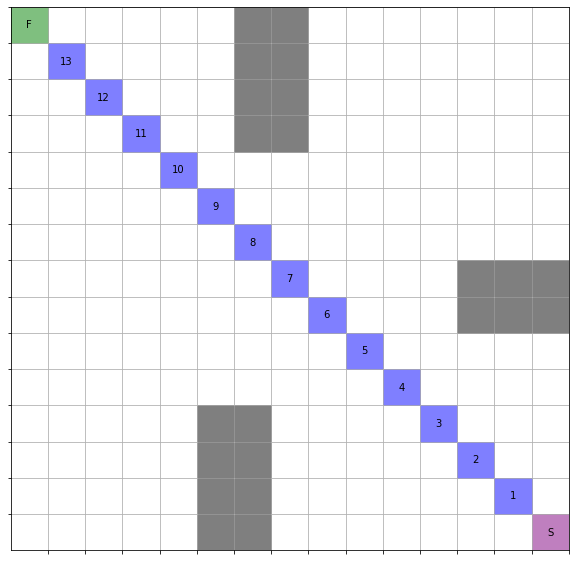

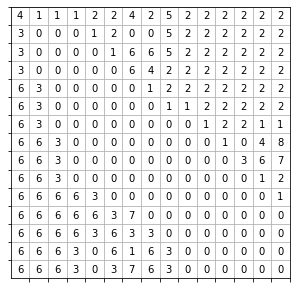

In [5]:
environment = Environment(actionPrice=-0.01, goalReward=1000, punish=-1)
agent = Agent(environment)
agent.take_action()
plotter(environment, agent)
agent.visualize_policy()

### Q2.

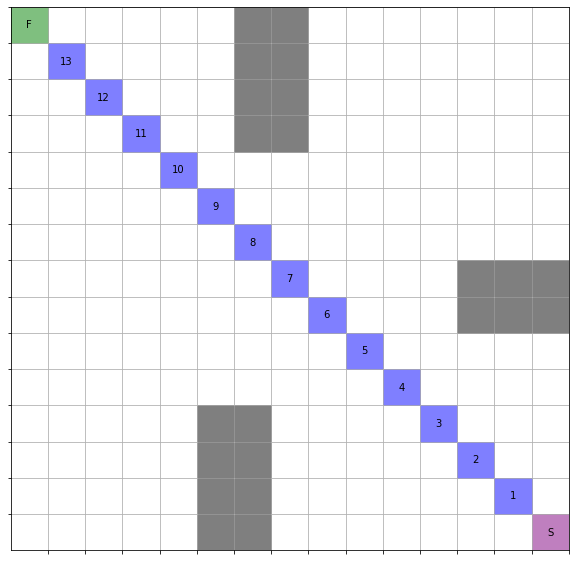

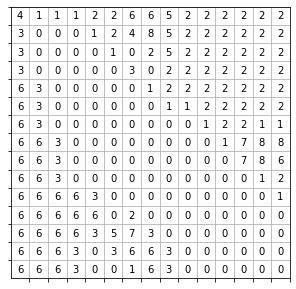

In [6]:
environment = Environment(actionPrice=0, goalReward=1000, punish=-0.01)
agent = Agent(environment)
agent.take_action()
plotter(environment, agent)
agent.visualize_policy()

### Q3.

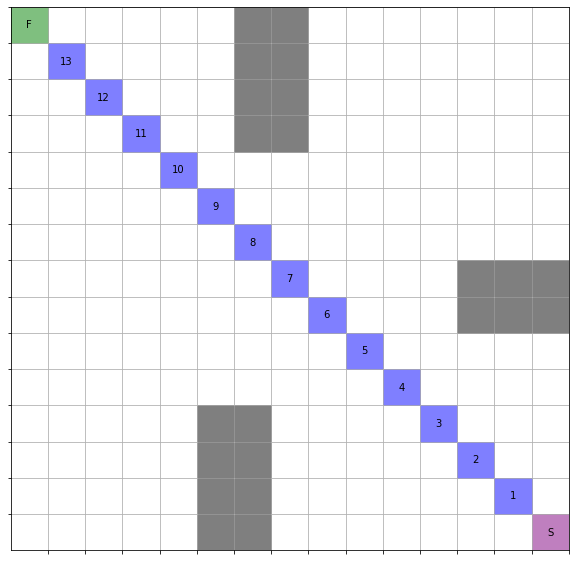

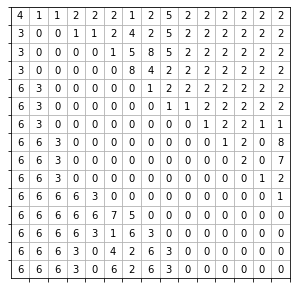

In [7]:
environment = Environment(actionPrice=-1, goalReward=100, punish=-10)
agent = Agent(environment, free_stay=True)
agent.take_action()
plotter(environment, agent)
agent.visualize_policy()

### Q4.

|_ Discount Factor: 0.1


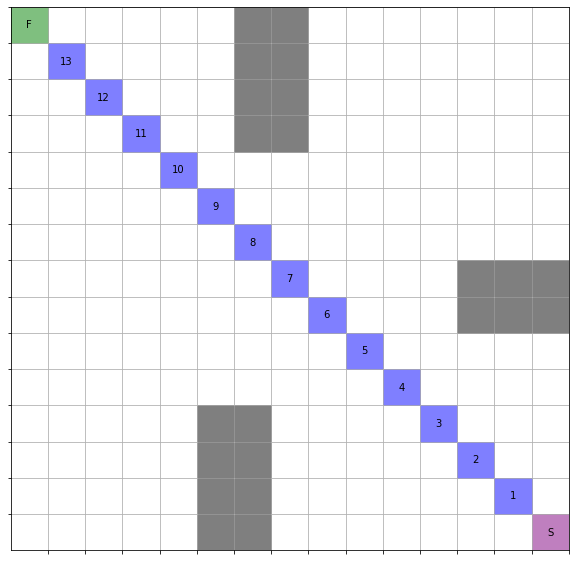

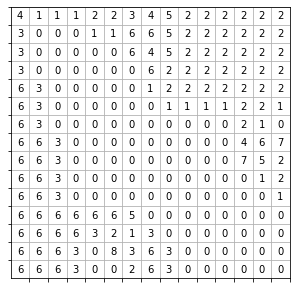

|_ Discount Factor: 0.01


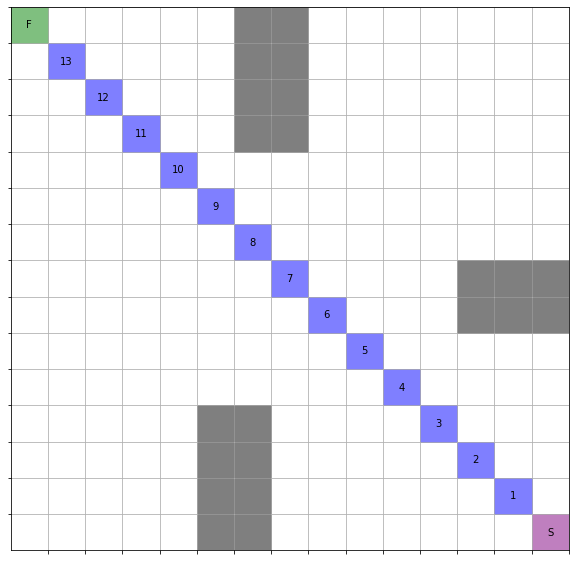

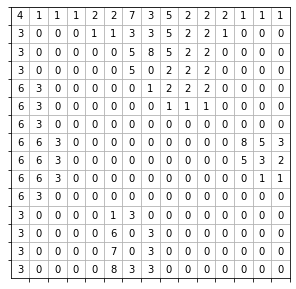

|_ Discount Factor: 0.001


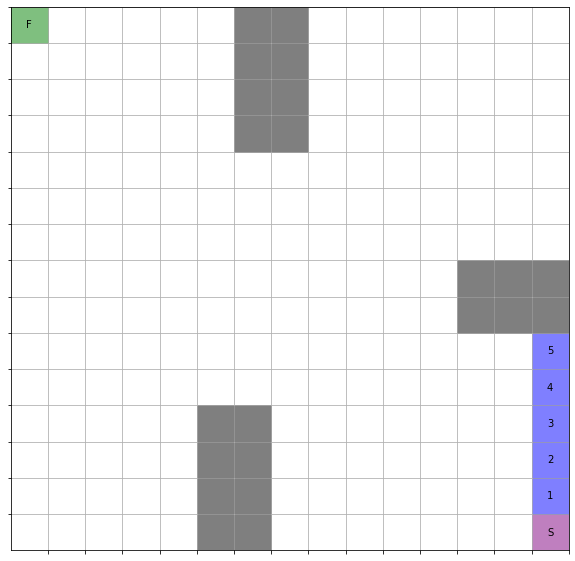

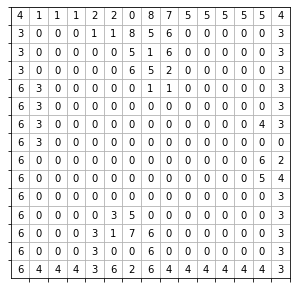

|_ Discount Factor: 0


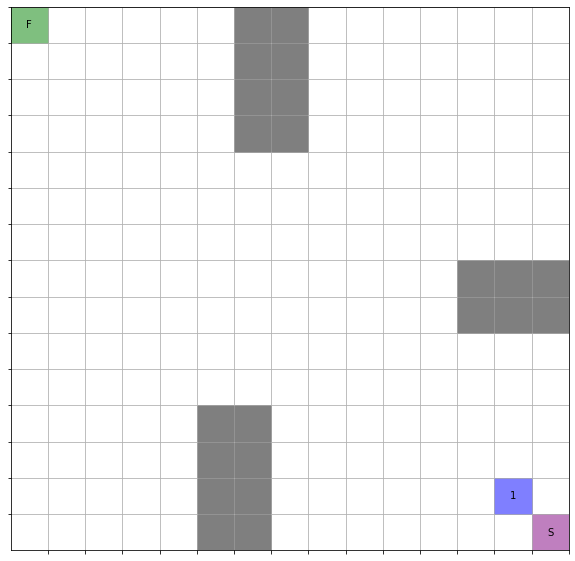

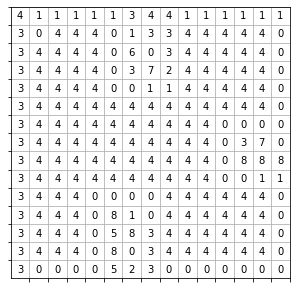

In [12]:
discount_factors = [0.1, 0.01, 0.001, 0]

for discount in discount_factors:
    print('|_ Discount Factor: {}'.format(discount))
    environment = Environment(actionPrice=-0.01, goalReward=1000, punish=-1)
    agent = Agent(environment, discount=discount)
    agent.take_action()
    plotter(environment, agent)    
    agent.visualize_policy()

### Q5.

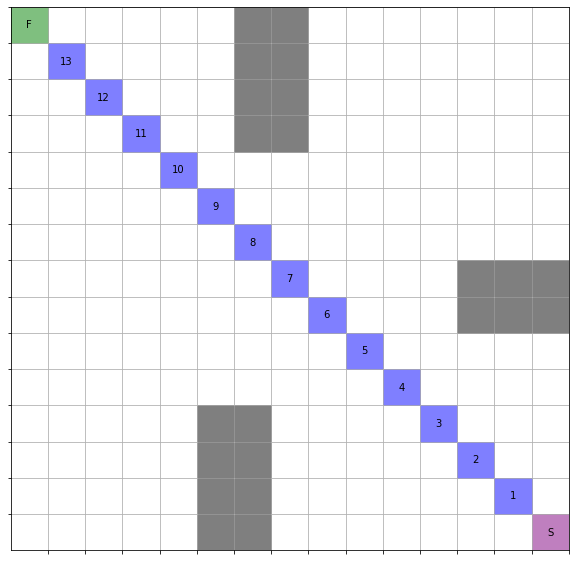

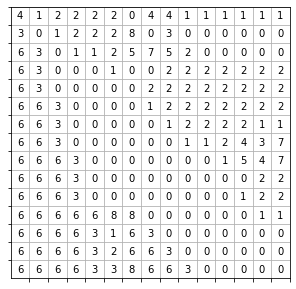

In [14]:
environment = Environment(actionPrice=-0.01, goalReward=1000, punish=-1)
agent = Agent(environment)
agent.take_action(mode='value')
plotter(environment, agent)
agent.visualize_policy()

### Extra.

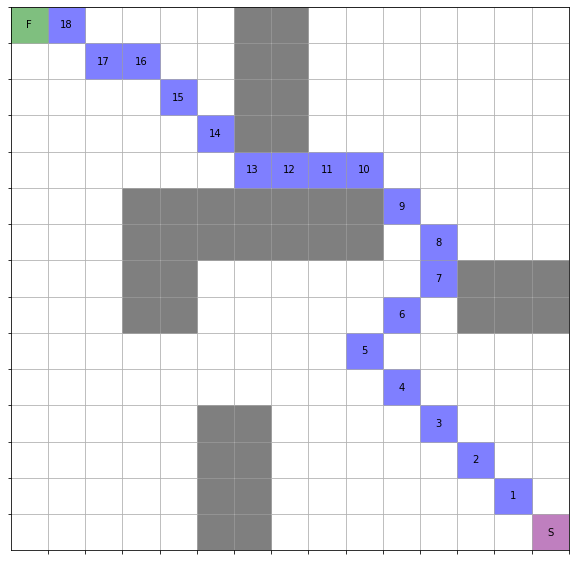

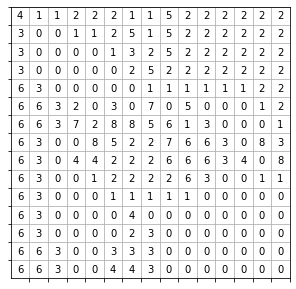

In [11]:
obstacles = [(1, 7), (1, 8), (2, 7), (2, 8), (3, 7), (3, 8), (4, 7), (4, 8), 
            (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10),
            (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10),
            (8, 4), (8, 5), (9, 4), (9, 5),
            (12, 6), (12, 7), (13, 6), (13, 7), (14, 6), (14, 7), (15, 6), (15, 7),
            (8, 13), (8, 14), (8, 15), (9, 13), (9, 14), (9, 15)]

environment = Environment(obstacles=obstacles, actionPrice=-0.01, goalReward=1000, punish=-1)
agent = Agent(environment)
agent.take_action()
plotter(environment, agent)
agent.visualize_policy()

### Finito